In [27]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.layers import LeakyReLU
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
import keras.metrics

# Import data

## Images

Get filenames

In [3]:
file_names = os.listdir('Data/images')
file_names[:5]

['Test_0.jpg', 'Test_1.jpg', 'Test_10.jpg', 'Test_100.jpg', 'Test_1000.jpg']

**Divide into Train and Test sets**

In [6]:
train_filenames = []
# test_filenames = []
for file_name in file_names:
    if 'Train' in file_name:
        train_filenames.append(file_name)
#     else: 
#         test_filenames.append(file_name)
print(f'There are {len(train_filenames)} train images')

There are 1821 train images


See a sample

In [7]:
img = cv2.imread(f'Data/images/{train_filenames[0]}')
img.shape

(1365, 2048, 3)

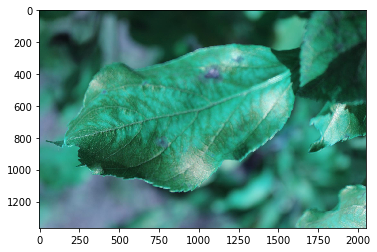

In [8]:
plt.imshow(img);

Load data into a numpy array with reduce image sizes

For train set

In [9]:
train_images = np.zeros((len(train_filenames), img.shape[0]//7,int((img.shape[0]//7)*1.5),3))
count = 0
for file in tqdm(train_filenames):
    image = cv2.imread(f'Data/images/{file}')
    small_img = cv2.resize(image, (int((img.shape[0]/7)*1.5), img.shape[0]//7), interpolation = cv2.INTER_CUBIC)
#     im_data = np.dot(small_img[...,:3], [0.2989, 0.5870, 0.1140])
#     im_data /= np.max(im_data)
    train_images[count,:,:,:] = small_img
    count += 1

For test set

In [9]:
# test_images = np.zeros((img.shape[0]//7,int((img.shape[0]/7)*1.5),(len(test_filenames))))
# count = 0
# for file in tqdm(test_filenames):
#     image = cv2.imread(f'Data/images/{file}')
#     small_img = cv2.resize(image, (int((img.shape[0]/7)*1.5), img.shape[0]//7), interpolation = cv2.INTER_CUBIC)
#     im_data = np.dot(small_img[...,:3], [0.2989, 0.5870, 0.1140])
#     im_data /= np.max(im_data)
#     test_images[:,:,count] = im_data
#     count += 1

See the new sample

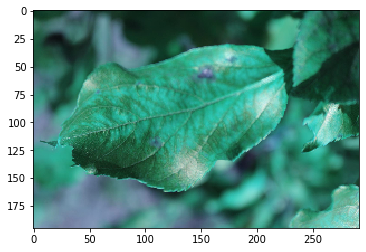

In [19]:
plt.imshow(np.array(train_images[0]).astype(np.int));

## Labels

In [20]:
train_labels = pd.read_csv('Data/train.csv')
# test_labels = pd.read_csv('Data/test.csv')
train_labels.shape#, test_labels.shape

(1821, 5)

In [21]:
train_labels.head(2)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0


In [13]:
# test_labels

The images have a different order

In [22]:
train_labels['idx'] = train_labels.image_id.apply(lambda x: train_filenames.index(x+'.jpg'))
train_labels.sort_values(by='idx', inplace=True)
# test_labels['idx'] = test_labels.image_id.apply(lambda x: test_filenames.index(x+'.jpg'))
# test_labels.sort_values(by='idx', inplace=True)
train_labels.head()

,image_id,healthy,multiple_diseases,rust,scab,idx
0,Train_0,0,0,0,1,0
1,Train_1,0,1,0,0,1
10,Train_10,0,0,1,0,2
100,Train_100,1,0,0,0,3
1000,Train_1000,0,0,1,0,4


# Modeling

In [23]:
X_train = train_images[:int(len(train_images)*0.8),:,:]
X_test = train_images[int(len(train_images)*0.8):,:,:]
X_train.shape, X_test.shape

((1456, 195, 292, 3), (365, 195, 292, 3))

In [24]:
y_train = np.array(train_labels[['healthy','multiple_diseases','rust','scab']].iloc[:int(train_images.shape[0]*0.8)].values.tolist())
y_test = np.array(train_labels[['healthy','multiple_diseases','rust','scab']].iloc[int(train_images.shape[0]*0.8):].values.tolist())
len(y_train), len(y_test)

(1456, 365)

In [46]:
batch_size = 64
epochs = 50
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [48]:
model = Sequential()

model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))

model.add(Conv2D(6, kernel_size=(3, 3),activation=LeakyReLU(alpha=0.1),padding='same',data_format='channels_last'))
model.add(Conv2D(6, kernel_size=(3, 3),activation=LeakyReLU(alpha=0.1),padding='same',data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))

model.add(Conv2D(16, kernel_size=(3, 3),activation=LeakyReLU(alpha=0.1),padding='same',data_format='channels_last'))
model.add(Conv2D(16, kernel_size=(3, 3),activation=LeakyReLU(alpha=0.1),padding='same',data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(16, activation=LeakyReLU(alpha=0.1)))
model.add(Dropout(0.25))

model.add(Dense(4, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              lr = 0.01,
              metrics=METRICS)

seqModel = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test),
          callbacks=[TQDMNotebookCallback()])

C:\Users\jvine\Anaconda3\envs\tf-gpu\lib\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [49]:
prediction = model.predict(X_test)

In [50]:
(y_test - prediction).sum()

-730.0

['Loss', 'TruePositives', 'FalsePositives', 'TrueNegatives', 'FalseNegatives', 'BinaryAccuracy', 'Precision', 'Recall', 'AUC']

In [51]:
model.evaluate(X_test, y_test)

365/365 [==============================] - 1s 3ms/step


[5.9542258987688035,
 247.0,
 848.0,
 247.0,
 118.0,
 0.3383561670780182,
 0.22557078301906586,
 0.6767123341560364,
 0.4511415660381317]

accuracy

In [52]:
seqModel.history['accuracy'][-1]

0.37688872

In [57]:
seqModel.history['auc']

[0.52508867,
 0.5136005,
 0.5024284,
 0.49931642,
 0.5005676,
 0.5011463,
 0.50571465,
 0.5034291,
 0.5083562,
 0.50332713,
 0.51006806,
 0.5191342,
 0.52242976,
 0.52953047,
 0.5278389,
 0.5301053,
 0.5291896,
 0.509272,
 0.5077839,
 0.5276997,
 0.53411174,
 0.5297619,
 0.53296703,
 0.5301053,
 0.52933455,
 0.52277523,
 0.5270147,
 0.51270604,
 0.5059671,
 0.5052656,
 0.50569725,
 0.47516027,
 0.4752747,
 0.4867216,
 0.48809522,
 0.4828297,
 0.48351648,
 0.48317313,
 0.47764182,
 0.46600273,
 0.4776786,
 0.46897894,
 0.46966574,
 0.4702381,
 0.47115383,
 0.46840662,
 0.4775641,
 0.4787088,
 0.47890264,
 0.46920788]

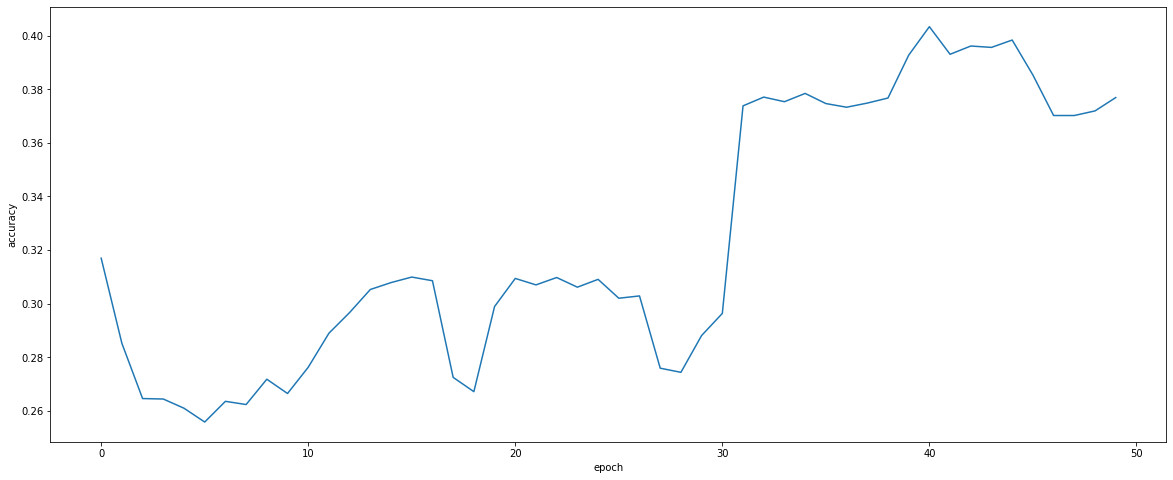

In [54]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(epochs), seqModel.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

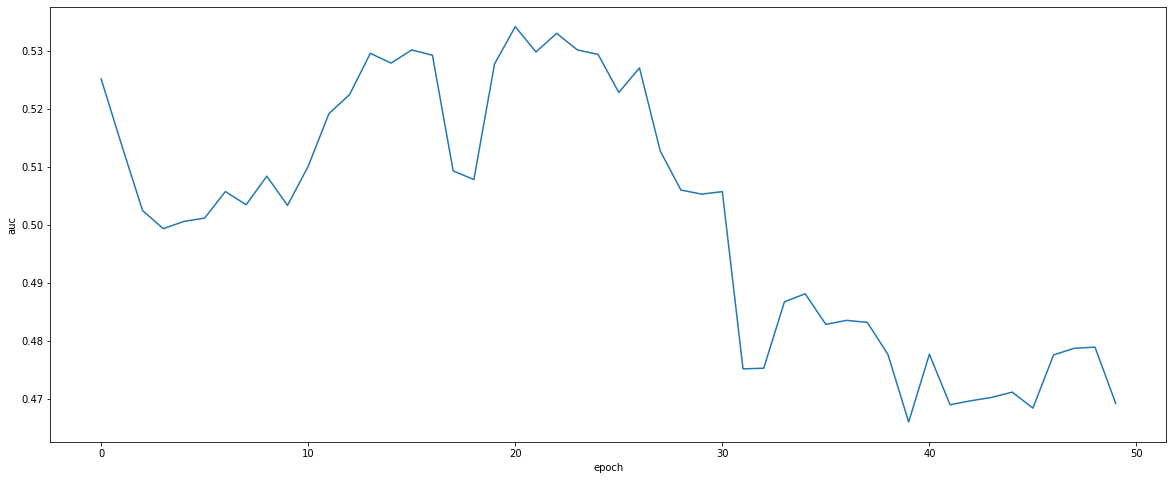

In [60]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(epochs), seqModel.history['auc'])
plt.xlabel('epoch')
plt.ylabel('auc')
plt.show()

In [55]:
y_test[:10]

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [56]:
prediction[:10]

array([[0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.]], dtype=float32)